## Imports

In [1]:
#imports
from astroquery.gaia import Gaia
import pandas as pd 
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import statsmodels.api as sm

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


## Get data
- Get Gaia data by query
- Read .csv data from APT

In [5]:
#read apt datatable
filename = "phaseone_apt.csv"
df_apt = pd.read_csv(filename) 
df_apt = df_apt[['CentroidRA', 'CentroidDec','Magnitude', 'MagUncertainty']]
#df_gaia = pd.read_csv("gaia.csv") #when gaia query doesnt work

In [129]:
from PIL import Image
im = Image.open('phaseone_small.tif')
min_ra = df_apt['CentroidRA'].min()
max_ra = df_apt['CentroidRA'].max()
min_dec = df_apt['CentroidDec'].min()
max_dec = df_apt['CentroidDec'].max()
print("Image info")
print("ra:" ,[min_ra, max_ra])
print("dec:", [min_dec, max_dec])
print("pixel scale:", math.sqrt((max_ra-min_ra)*(max_dec-min_dec)/im.size[0]/im.size[1])*3600, "arcsec/pixel")

Image info
ra: [170.002925, 194.99421999999998]
dec: [40.000389, 54.996106999999995]
pixel scale: 19.485981617348504 arcsec/pixel


In [126]:
#gaia query
query = "SELECT ALL gaia_source.source_id,gaia_source.ra,gaia_source.dec,\
gaia_source.pmra,gaia_source.pmdec,gaia_source.phot_bp_mean_mag FROM gaiadr2.gaia_source WHERE CONTAINS\
(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),BOX('ICRS'," +\
str((df_apt['CentroidRA'].min()+df_apt['CentroidRA'].max())/2)+","+\
str((df_apt['CentroidDec'].min()+df_apt['CentroidDec'].max())/2)+","+\
str((df_apt['CentroidRA'].max()-df_apt['CentroidRA'].min()))+","+\
str((df_apt['CentroidDec'].max()-df_apt['CentroidDec'].min()))+"))=1 AND \
(gaiadr2.gaia_source.phot_bp_mean_mag<=15)" #20

job = Gaia.launch_job_async(query)  

KeyboardInterrupt: 

In [99]:
#get resulting gaia datatable
r = job.get_results() 
df_gaia = r.to_pandas()

In [6]:
#optional: cut part of data
df_gaia = df_gaia.query('dec<55').query('dec>40').query('ra>170').query('ra<195').dropna().reset_index(drop=True)
df_apt = df_apt.query('CentroidDec<55').query('CentroidDec>40').\
query('CentroidRA>170').query('CentroidRA<195').dropna().reset_index(drop=True)

## Functions

In [7]:
def p_scatter(df1, df2, x, y, xlim =[0,0] , ylim=[0,0], lr1 = False, lr2 = False):
    '''
    This function uses matplotlib.pyplot to graph two functions and fix axis (calculated if not given).
    df2 should be the smaller subset.
    '''
    axes = plt.gca()
    plt.scatter(df1[x], df1[y]) 
    plt.scatter(df2[x], df2[y]) 
    if xlim == [0,0]:
        xlim = [df[x].min()-(df[x].max()-df[x].min())*0.05, df[x].max() + (df[x].max()-df[x].min())*0.05]
    if ylim == [0,0]:
        ylim = [df[y].min()-(df[y].max()-df[y].min())*0.05, df[y].max() + (df[y].max()-df[y].min())*0.05]
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    plt.xlabel(x)
    plt.ylabel(y)
    if lr1 == True: 
        model = sm.OLS(df1[y], sm.add_constant(df1[x])).fit() 
        pred = df1[x]*model.params[x]+model.params['const']
        plt.plot(df1[x],pred,'#2678b2')
    if lr2 == True:
        model = sm.OLS(df2[y], sm.add_constant(df2[x])).fit() 
        pred = df2[x]*model.params[x]+model.params['const']
        plt.plot(df2[x],pred,'#fd7f28')

## Match data

Text(0.5,1,'Position match')

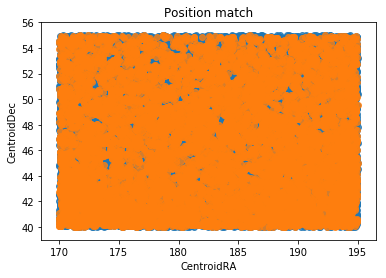

In [100]:
#Check ra and dec matching
sns.regplot('ra', 'dec', data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec', data=df_apt, fit_reg = False).set_title("Position match")

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of difference in match')

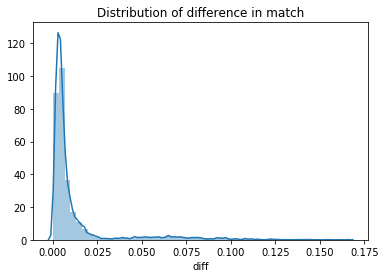

In [101]:
#match
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','pmra','pmdec',\
                           'CentroidRA','CentroidDec','Magnitude','diff'])
dist = scipy.spatial.distance.cdist(df_apt[['CentroidRA', 'CentroidDec']], df_gaia[['ra', 'dec']]) 
min_dist = np.argmin(dist, axis=1) 

m = 0
while m < len(df_apt): 
    n = min_dist[m]   
    df = df.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n],\
                    'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n],\
                    'pmra': df_gaia['pmra'][n], 'pmdec': df_gaia['pmdec'][n],\
                    'CentroidRA': df_apt['CentroidRA'][m],'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': dist[m][n]
                   }, ignore_index=True)
    #if m == int(round(len(df_apt)/10)):
    #    print(u"\u2588")
    m+=1
    
sns.distplot(df['diff']).set_title('Distribution of difference in match')

In [102]:
#delete duplicates
maxdiff = 0.02
querystr = "diff<" + str(maxdiff)
df = df.query(querystr)
df = df.sort_values('diff').drop_duplicates('ra')
df = df.sort_values('diff').drop_duplicates('CentroidRA')

In [103]:
print('Gaia:', len(df_gaia), '\nAPT:', len(df_apt), '\nMatched:', len(df), '('+ \
      str(round(len(df)/len(df_apt)*100,2))+"% of all APT results)")

Gaia: 31519 
APT: 9006 
Matched: 6794 (75.44% of all APT results)


### Regression for magnitude

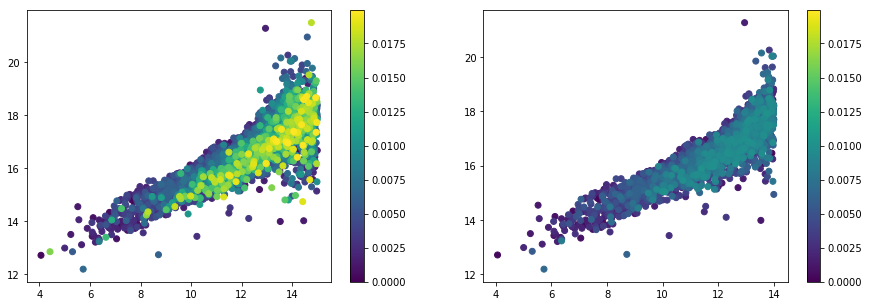

In [104]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
plt.scatter(df['phot_bp_mean_mag'], df['Magnitude'], c = df['diff']) 
plt.clim(0,df['diff'].max())
plt.colorbar()

ax1 = fig.add_subplot(122)
df_ = df.query('phot_bp_mean_mag<14').query('diff<0.01')
plt.scatter(df_['phot_bp_mean_mag'], df_['Magnitude'], c = df_['diff']) 
plt.clim(0,df['diff'].max())
plt.colorbar()

In [105]:
X = df_["phot_bp_mean_mag"] 
y = df_["Magnitude"]
X = sm.add_constant(X) #intercept 

model = sm.OLS(y, X).fit() 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Magnitude   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                 2.845e+04
Date:                Sat, 28 Sep 2019   Prob (F-statistic):               0.00
Time:                        23:04:33   Log-Likelihood:                -2594.0
No. Observations:                5648   AIC:                             5192.
Df Residuals:                    5646   BIC:                             5205.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.6552      0.040    240.886      0.000       9.577       9.734
phot_bp_mean_mag     0.5789      0.003    168.672      0.000       0.572       0.586
==============================================================================
Omnibus:                      929.014   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18157.881
Skew:                           0.098   Prob(JB):                         0.00
Kurtosis:                      11.782   Cond. No.                         92.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
df['mag_mod'] =  model.params['phot_bp_mean_mag']*df.phot_bp_mean_mag + model.params['const']
df['diff_mag'] = df['mag_mod'] - df['Magnitude']

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of difference in match')

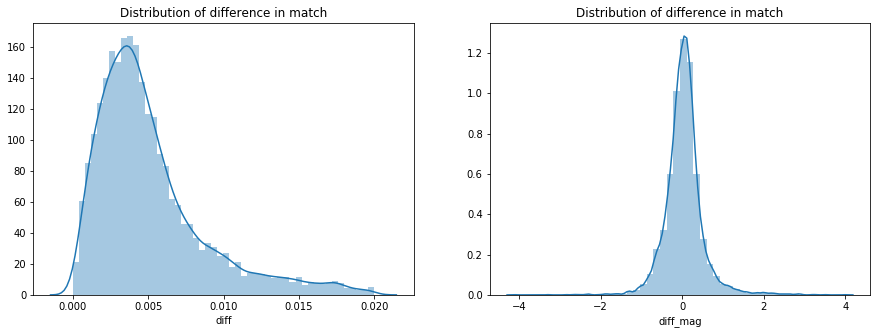

In [107]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(122)
sns.distplot(df['diff_mag']).set_title('Distribution of difference in match')

In [108]:
#new vars
df['Δra'] = df.apply(lambda row: row.ra - row.CentroidRA, axis = 1) 
df['Δdec'] = df.apply(lambda row: row.dec - row.CentroidDec, axis = 1) 
df['Δmag'] = df.apply(lambda row: row.Magnitude - row.phot_bp_mean_mag, axis = 1) 

#subset
df_filtered = df.query('diff<0.01').query('diff_mag<6').query('diff_mag>-2').query('diff_mag<2')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of difference in match')

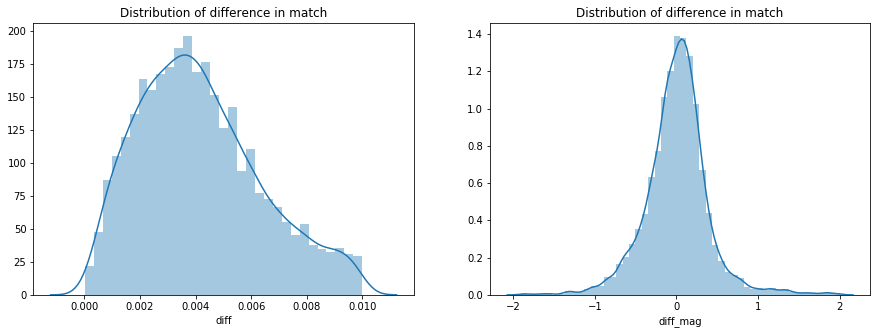

In [109]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.distplot(df_filtered['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(122)
sns.distplot(df_filtered['diff_mag']).set_title('Distribution of difference in match')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


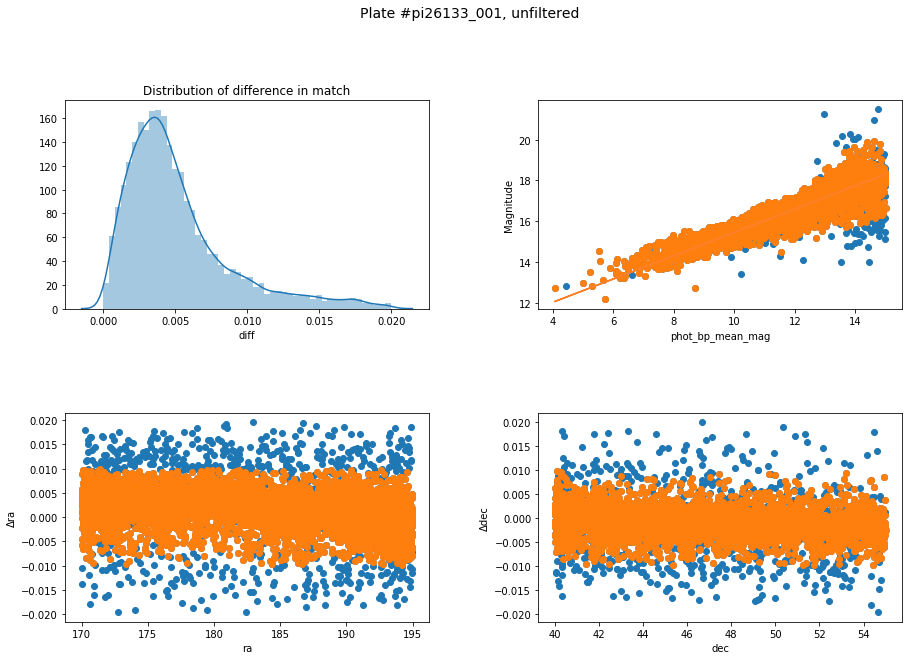

In [110]:
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate #pi26133_001, unfiltered", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(2,2,2)
p_scatter(df, df_filtered, 'phot_bp_mean_mag', 'Magnitude', lr2 = True)
ax3 = fig.add_subplot(2,2,3)
#sns.regplot('ra','Δra',data=df).set_title('ra vs. Δra')
p_scatter(df, df_filtered, 'ra', 'Δra')
ax4 = fig.add_subplot(2,2,4)
p_scatter(df, df_filtered, 'dec', 'Δdec')

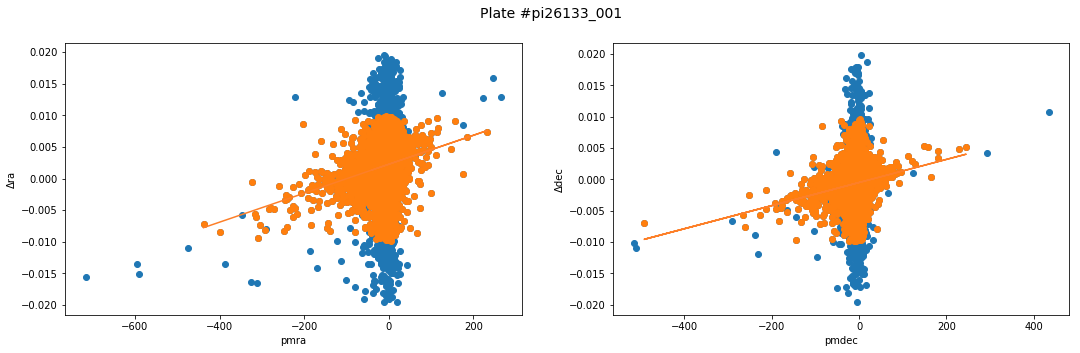

In [113]:
#graphing proper motion
df = df.dropna().reset_index(drop=True)
df_filtered = df_filtered.dropna().reset_index(drop=True)
fig = plt.figure(figsize=(18,5))#graph size
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
ax1 = fig.add_subplot(121)
p_scatter(df, df_filtered, 'pmra', 'Δra', lr2 = True)
ax2 = fig.add_subplot(122)
p_scatter(df, df_filtered, 'pmdec', 'Δdec', lr2 = True)

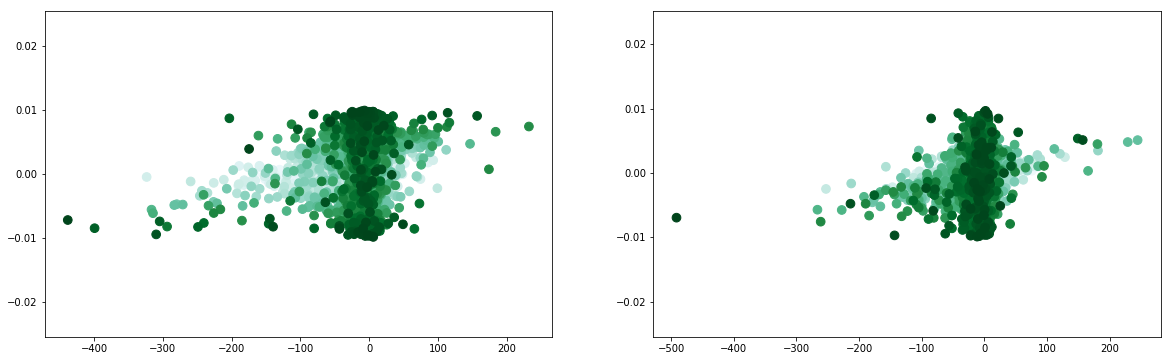

In [114]:
df_na = df_filtered.dropna().reset_index(drop=True)#for regression
fig = plt.figure(figsize=(20,6))#graph size

ax1 = fig.add_subplot(1,2,1)
plt.scatter(df_na["pmra"], df_na["Δra"], c=df_na["diff"], s=75, cmap="BuGn")
plt.gca()

ax2 = fig.add_subplot(1,2,2)
plt.scatter(df_na["pmdec"], df_na["Δdec"], c=df_na["diff"], s=75, cmap="BuGn")
plt.gca()